Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2024-11-13 12:42:57--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.005s  

2024-11-13 12:42:58 (116 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2024-11-13 12:42:58--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.c

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
# YOUR CODE HERE
reviews_words = []
for review in reviews:
  review_words = []
  for sentence in review["content"]:
    review_words.extend([word for word, tag in sentence])
  reviews_words.append(review_words)

def load_sentiment_lexicon(file_path,flag):
    lexicon = {}
    with open(file_path, mode="r", encoding="utf-8") as f:
        for line in f:
            # Extract word and priorpolarity directly from the line
            word = line.split("word1=")[-1].split()[0]
            prior_polarity = line.split("priorpolarity=")[-1].strip()
            type_value = line.split()[0].split('=')[1]  # Get the value after 'type='

            if flag == None:
              # Map prior polarity to numerical values
              if prior_polarity == "positive":
                  sentiment = 1
              elif prior_polarity == "negative":
                  sentiment = -1
              else:
                  sentiment = 0

            if flag != None:
              if prior_polarity == "positive" and type_value == "strongsubj":
                  sentiment = 2  # Add 2 for strong type
              elif prior_polarity == "positive" and type_value == "weaksubj":
                  sentiment = 1
              elif prior_polarity == "negative" and type_value == "strongsubj":
                  sentiment = -2
              elif prior_polarity == "negative" and type_value == "weaksubj":
                  sentiment = -1
              else:
                  sentiment = 0

            lexicon[word] = sentiment
    return lexicon

def get_sentiment_list(words, file_path, flag=None):
    lexicon = load_sentiment_lexicon(file_path,flag)
    return [lexicon.get(word, 0) for word in words]  # Default to 0 if word not found


sentiments = []
for k in range(len(reviews)):
  sentiments.append(get_sentiment_list(reviews_words[k], "sent_lexicon"))

In [ ]:
sentiment_sum = []
classifications = []

for k in range(len(reviews)):
  sentiment_sum.append(sum(sentiments[k]))
  if sum(sentiments[k]) > 8:
    classifications.append(1)
  else:
    classifications.append(-1)

# print(sentiment_sum)
# print(classifications)

In [ ]:
# Create a list to store sentiments ground truth
GT = []

# Open the JSON file line by line
with open("reviews.json", mode="r", encoding="utf-8") as f:
  for i, r in enumerate(reviews):
    if r["sentiment"] == "POS":
      GT.append(1)
    elif r["sentiment"] == "NEG":
      GT.append(-1)

# print(GT)

token_results = [None] * 2000
for k in range(len(reviews)):
  if GT[k] == classifications[k]:
    token_results[k] = 1
  else:
    token_results[k] = 0



In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = token_results
token_accuracy = sum(token_results)/len(token_results)
print("Accuracy: %2f" % token_accuracy)

Accuracy: 0.679500


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
# YOUR CODE HERE
sentiments2 = []

for k in range(len(reviews)):
  sentiments2.append(get_sentiment_list(reviews_words[k], "sent_lexicon","flagged"))


In [ ]:
classifications2=[]
sentiment_sum2 = []

for k in range(len(reviews)):
  sentiment_sum2.append(sum(sentiments2[k]))
  if sum(sentiments2[k]) > 10:
    classifications2.append(1)
  else:
    classifications2.append(-1)

magnitude_results = [None] * 2000
for k in range(len(reviews)):
  if GT[k] == classifications2[k]:
    magnitude_results[k] = 1
  else:
    magnitude_results[k] = 0

print(sentiment_sum2)

[19, 9, 9, 0, 1, -13, -13, -19, -29, 0, 6, 2, -28, -1, 2, -12, -9, -1, 25, 7, 2, -7, -11, 4, -4, 29, 17, -21, 14, -2, -14, 12, -4, 24, -25, -3, 5, -7, -12, -2, -18, -20, 22, 5, 2, -4, -14, 3, -3, 4, 21, 16, 6, 14, -1, 3, 5, -7, 7, 31, -6, 40, -11, -17, -19, -13, -5, -3, -9, -36, 16, 13, -7, 10, -5, -5, -27, 17, -10, -7, -4, -1, -17, -7, -16, 9, -24, -18, 26, -6, 19, -8, 19, -11, 28, -2, -14, 6, -12, 2, -1, -12, -31, 38, -3, 14, -8, 47, 0, -1, 7, 3, 0, -15, 3, 14, 9, 1, -22, 9, 30, -12, 16, -5, 11, 15, 18, -4, -12, -15, -9, 18, -5, -1, 25, 26, -15, -9, 35, -10, 54, 14, 19, -3, -36, 18, 0, 1, -19, 4, -19, 16, 18, -7, -9, -18, 11, 1, -14, -1, -42, 17, -10, 17, -14, 1, 28, 15, -3, 14, -1, 1, 14, -3, -34, -16, 21, 8, -7, -4, -41, 7, 0, -4, -3, 2, 8, 7, -20, -2, -1, -7, 15, -8, 2, 6, -15, -30, 2, 8, 32, 6, 7, -20, -13, -1, 13, -3, -22, -3, 0, 10, -27, -27, 23, -3, 8, -39, 17, 13, -7, -14, -5, 11, -10, -2, -15, 14, -24, 16, 28, 17, 27, 15, -6, -1, 11, 3, 4, -7, -13, -24, 23, -5, -13, -7, 16, 

In [ ]:
magnitude_results = magnitude_results# a list of binary indicators
magnitude_accuracy = sum(magnitude_results)/len(magnitude_results)
print("Accuracy: %2f" % magnitude_accuracy)

Accuracy: 0.690000


#### (Q.1.3) Make a barplot of the two results (0.5pt)

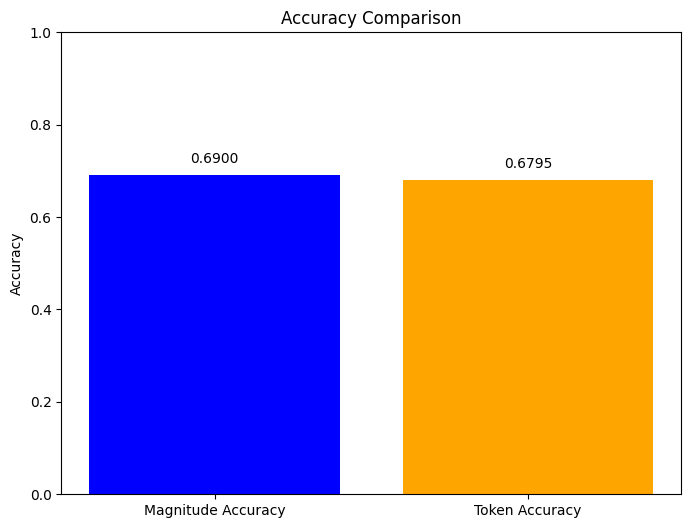

In [ ]:
# YOUR CODE HERE
# Define the accuracy values
accuracies = [magnitude_accuracy, token_accuracy]
labels = ['Magnitude Accuracy', 'Token Accuracy']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Accuracy Comparison')

# Add the value on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')

# Show the plot
plt.show()


#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Since there are on average more positive than negative words in a given review due to the way the english language is structured it is expected that in lenghtier reviews the amount of positive words overwhelms the amount of negative words increasing the sentiment sum while on shorter reviews the amount tends to be smaller thus decreasing the sentiment sum. If a static threshold is used the afformentioned edge cases are likely to be missclassified therefore we need a new approach to deal with this problem i.e a dynamic threshold. The dynamic threshold is the product of our old static threshold with the length of the review and a constant 10/1000 (the constant is to bring the threshold value to a value similar to our static threshold). The reasoning behind this mechanism is that the threshold is analogous with the review length increasing as the length increases since in a lengthier review we expect the sentiment sum to be high and in the opposite case with small reviews we get a small threshold which accounts for the smaller sentiment sum.

In [ ]:
# YOUR CODE HERE

classifications2=[]
sentiment_sum2 = []

for k in range(len(reviews)):
  sentiment_sum2.append(sum(sentiments2[k]))
  if sum(sentiments2[k]) > (10/1000)*len(reviews_words[k]):
    classifications2.append(1)
  else:
    classifications2.append(-1)

magnitude_results = [None] * 2000
for k in range(len(reviews)):
  if GT[k] == classifications2[k]:
    magnitude_results[k] = 1
  else:
    magnitude_results[k] = 0

magnitude_results = magnitude_results# a list of binary indicators
magnitude_accuracy = sum(magnitude_results)/len(magnitude_results)
print("Accuracy: %2f" % magnitude_accuracy)

Accuracy: 0.675500


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


In [ ]:
from collections import defaultdict
with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

# Define training function
def train_naive_bayes(reviews):
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()


    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for sentence in review["content"]:
            for word, pos in sentence:
                word = word.lower()
                word_counts[sentiment][word] += 1 # Update word count for sentiment
                vocab.add(word)

    # Identify words that only appear in one class and remove them
    single_class_words = {word for word in vocab if (word in word_counts['POS']) != (word in word_counts['NEG'])}
    vocab = vocab - single_class_words

    # Calculate priors for both classes
    total_reviews = sum(class_counts.values())
    class_priors = {cls: count / total_reviews for cls, count in class_counts.items()}

    # Calculate word likelihoods
    word_likelihoods = {
        cls: {
            word: word_counts[cls][word] / (sum(word_counts[cls].values()))
            for word in vocab
        }
        for cls in class_counts
    }

    return class_priors, word_likelihoods, vocab, word_counts

# Define prediction function
def predict_naive_bayes(review, class_priors, word_likelihoods, vocab):
    scores = {}

    # For each class, compute log-probabilities
    for cls in class_priors:
        log_prob = math.log(class_priors[cls])

        for sentence in review["content"]:
            for word, pos in sentence:
                word = word.lower()
                if word in vocab and word_likelihoods[cls].get(word, 0)> 0:
                    log_prob += math.log(word_likelihoods[cls][word])
        scores[cls] = log_prob

    # Select the class with the highest log-probability
    return max(scores, key=scores.get)

#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

This would cause a bias towards one class in the classification process. If we keep a word for a class that has seen the word while skipping it for the other class, it would increase the log probability for the class that has seen the words. If we do this for a significant amount of words, a bias might arise potentially pointing the prediction towards the class which has seen more words.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# YOUR CODE HERE
train_reviews = [r for r in reviews if int(r["cv"]) < 900]
test_reviews = [r for r in reviews if int(r["cv"]) > 899]

class_priors_train, word_likelihoods_train, vocab_train, _ = train_naive_bayes(train_reviews)

correct_predictions = 0
for test_r in test_reviews:
  pred = predict_naive_bayes(test_r, class_priors_train, word_likelihoods_train, vocab_train)
  if pred == test_r["sentiment"]:
    correct_predictions += 1

accuracy = correct_predictions / len(test_reviews)
print("Acurracy: ",accuracy)





Acurracy:  0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In this case, accuracy is not a good evaluation metric as it does not give us insight on how the predictions are balanced (ratio of POS/NEG predictions). A model that predicts 'POS' very often due to the imbalanced training data, can still achieve great accuracy when the test set also contains sinificantly more positive examples than negative one. The addition of a confusion matrix can help us to gain more insgiht on the model's prediction behaviour and reveal possible class imablances in the dataset. The classification accuracy dropped a bit, but is still fairly good due to the training and test set which both contain significantly more positive instances than negative ones.

In [ ]:
# YOUR CODE HERE
train_reviews = [r for r in reviews if r["sentiment"] == "POS" or (int(r["cv"]) <= 89 and r["sentiment"] == "NEG")]
test_reviews = [r for r in reviews if r["sentiment"] == "POS" or (900 <= int(r["cv"]) <= 909 and r["sentiment"] == "NEG")]

class_priors_train, word_likelihoods_train, vocab_train, _ = train_naive_bayes(train_reviews)

correct_predictions = 0
for test_r in test_reviews:
  pred = predict_naive_bayes(test_r, class_priors_train, word_likelihoods_train, vocab_train)
  if pred == test_r["sentiment"]:
    correct_predictions += 1

accuracy = correct_predictions / len(test_reviews)
print("Acurracy: ",accuracy)


Acurracy:  0.7376237623762376


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE

def train_naive_bayes_smooth(reviews):
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()


    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for sentence in review["content"]:
            for word, pos in sentence:
                word = word.lower()
                word_counts[sentiment][word] += 1 # Update word count for sentiment
                vocab.add(word)


    # Calculate priors for both classes
    total_reviews = sum(class_counts.values())
    class_priors = {cls: count / total_reviews for cls, count in class_counts.items()}

    # Calculate word likelihoods with Laplace smoothing
    vocab_size = len(vocab)
    word_likelihoods = {
        cls: {
            word: (word_counts[cls][word] + 1) / (sum(word_counts[cls].values()) + vocab_size)
            for word in vocab
        }
        for cls in class_counts
    }

    return class_priors, word_likelihoods, vocab

# Define prediction function
def predict_naive_bayes_smooth(review, class_priors, word_likelihoods, vocab):
    scores = {}

    # For each class, compute log-probabilities
    for cls in class_priors:
        log_prob = math.log(class_priors[cls])

        for sentence in review["content"]:
            for word, pos in sentence:
                word = word.lower()
                if word in vocab: # Skip words not in vocab
                    log_prob += math.log(word_likelihoods[cls].get(word))
        scores[cls] = log_prob

    # Select the class with the highest log-probability
    return max(scores, key=scores.get)


# YOUR CODE HERE
train_reviews = [r for r in reviews if int(r["cv"]) < 900]
test_reviews = [r for r in reviews if int(r["cv"]) > 899]

class_priors_train, word_likelihoods_train, vocab_train = train_naive_bayes_smooth(train_reviews)

correct_predictions = 0
for test_r in test_reviews:
  pred = predict_naive_bayes_smooth(test_r, class_priors_train, word_likelihoods_train, vocab_train)
  if pred == test_r["sentiment"]:
    correct_predictions += 1

accuracy = correct_predictions / len(test_reviews)
print("Acurracy: ",accuracy)


Acurracy:  0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
# YOUR CODE HERE
def cross_val_round_rob(reviews, num_folds = 10):

  # Split reviews in 10 folds using round robin
  folds = [[] for _ in range(num_folds)]
  for i, review in enumerate(reviews):
    fold_index = i % num_folds
    folds[fold_index].append(review)

  accuracies = []
  for i in range(num_folds):
    # Hold out one fold for testing, use the remaining folds for training
    test_set = folds[i]
    train_set = [review for j in range(num_folds) if j != i for review in folds[j]]

    # Train the naive bayes classifier with Laplacian smoothing
    class_priors_train, word_likelihoods_train, vocab_train = train_naive_bayes_smooth(train_set)

    # Evaluate performance
    correct_predictions = 0
    for test_review in test_set:
      pred = predict_naive_bayes_smooth(test_review, class_priors_train, word_likelihoods_train, vocab_train)
      if pred == test_review["sentiment"]:
        correct_predictions += 1

    # Calculate accuracy per fold individually
    fold_acc = correct_predictions / len(test_set)
    accuracies.append(fold_acc)
    print(f"Accuracy for fold {i + 1}: {fold_acc:.4f}")

  # Calculate average accuracy over all folds
  avg_acc = sum(accuracies) / num_folds
  print(f"\nAverage accuracy across 10 folds: {avg_acc:.4f}")
  return accuracies, avg_acc

# Run the cross-validation
accuracy_list, average_accuracy = cross_val_round_rob(reviews)




Accuracy for fold 1: 0.7900
Accuracy for fold 2: 0.8350
Accuracy for fold 3: 0.8050
Accuracy for fold 4: 0.8250
Accuracy for fold 5: 0.7800
Accuracy for fold 6: 0.8450
Accuracy for fold 7: 0.8300
Accuracy for fold 8: 0.7750
Accuracy for fold 9: 0.8300
Accuracy for fold 10: 0.8400

Average accuracy across 10 folds: 0.8155


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [ ]:
# YOUR CODE HERE
variance = sum((x - average_accuracy)**2 for x in accuracy_list) / len(accuracy_list)
print("Variance: ", variance)

Variance:  0.0006022499999999986


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE

stemmer = PorterStemmer()

def train_naive_bayes_stem(reviews):
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()


    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for sentence in review["content"]:
            for word, pos in sentence:
                word = stemmer.stem(word.lower())
                word_counts[sentiment][word] += 1 # Update word count for sentiment
                vocab.add(word)

    # Identify words that only appear in one class and remove them
    single_class_words = {word for word in vocab if (word in word_counts['POS']) != (word in word_counts['NEG'])}
    vocab = vocab - single_class_words

    # Calculate priors for both classes
    total_reviews = sum(class_counts.values())
    class_priors = {cls: count / total_reviews for cls, count in class_counts.items()}

    # Calculate word likelihoods
    word_likelihoods = {
        cls: {
            word: word_counts[cls][word] / (sum(word_counts[cls].values()))
            for word in vocab
        }
        for cls in class_counts
    }

    return class_priors, word_likelihoods, vocab

# Define prediction function
def predict_naive_bayes_stem(review, class_priors, word_likelihoods, vocab):
    scores = {}

    # For each class, compute log-probabilities
    for cls in class_priors:
        log_prob = math.log(class_priors[cls])

        for sentence in review["content"]:
            for word, pos in sentence:
                word = stemmer.stem(word.lower())
                if word in vocab and word_likelihoods[cls].get(word, 0)> 0:
                    log_prob += math.log(word_likelihoods[cls][word])
        scores[cls] = log_prob

    # Select the class with the highest log-probability
    return max(scores, key=scores.get)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [ ]:
# YOUR ANSWER HERE
def cross_val_round_rob_stem(reviews, num_folds = 10):

  # Split reviews in 10 folds using round robin
  folds = [[] for _ in range(num_folds)]
  for i, review in enumerate(reviews):
    fold_index = i % num_folds
    folds[fold_index].append(review)

  accuracies = []
  for i in range(num_folds):
    # Hold out one fold for testing, use the remaining folds for training
    test_set = folds[i]
    train_set = [review for j in range(num_folds) if j != i for review in folds[j]]

    # Train the naive bayes classifier with stemming
    class_priors_train, word_likelihoods_train, vocab_train = train_naive_bayes_stem(train_set)

    # Evaluate performance
    correct_predictions = 0
    for test_review in test_set:
      pred = predict_naive_bayes_stem(test_review, class_priors_train, word_likelihoods_train, vocab_train)
      if pred == test_review["sentiment"]:
        correct_predictions += 1

    # Calculate accuracy per fold individually
    fold_acc = correct_predictions / len(test_set)
    accuracies.append(fold_acc)
    print(f"Accuracy for fold {i + 1}: {fold_acc:.4f}")

  # Calculate average accuracy over all folds
  avg_acc = sum(accuracies) / num_folds
  print(f"\nAverage accuracy across 10 folds: {avg_acc:.4f}")
  return accuracies, avg_acc

# Run the cross-validation
accuracy_list, average_accuracy = cross_val_round_rob_stem(reviews)



Accuracy for fold 1: 0.7750
Accuracy for fold 2: 0.8350
Accuracy for fold 3: 0.8050
Accuracy for fold 4: 0.8650
Accuracy for fold 5: 0.7850
Accuracy for fold 6: 0.8450
Accuracy for fold 7: 0.8100
Accuracy for fold 8: 0.7900
Accuracy for fold 9: 0.8300
Accuracy for fold 10: 0.8150

Average accuracy across 10 folds: 0.8155


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# Without Stemming
def train_naive_bayes_no_stem(reviews):
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()

    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for sentence in review["content"]:
            for word, pos in sentence:
                word = word.lower()  # No stemming, use word as is
                word_counts[sentiment][word] += 1
                vocab.add(word)

    return vocab


# With Stemming
def train_naive_bayes_stem(reviews):
    stemmer = PorterStemmer()
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()

    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for sentence in review["content"]:
            for word, pos in sentence:
                word = stemmer.stem(word.lower())  # Apply stemming
                word_counts[sentiment][word] += 1
                vocab.add(word)

    return vocab


# Running the functions
train_reviews = [r for r in reviews if int(r["cv"]) < 900]  # Train on reviews with cv < 900

# Without stemming
vocab_no_stem = train_naive_bayes_no_stem(train_reviews)
print(f"Vocabulary size without stemming: {len(vocab_no_stem)}")

# With stemming
vocab_stem = train_naive_bayes_stem(train_reviews)
print(f"Vocabulary size with stemming: {len(vocab_stem)}")


Vocabulary size without stemming: 45348
Vocabulary size with stemming: 32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# Preprocessing function to improve efficiency
def preprocess_ngrams(reviews, n):
    for review in reviews:
        all_words = [word.lower() for sentence in review["content"] for word, pos in sentence]
        review_ngrams = [[] for _ in range(n)] # Create empty list for each n-gram level

        for i in range(1, n + 1):
            ngrams_generated = [" ".join(ngram) for ngram in ngrams(all_words, i)]
            review_ngrams[i - 1].extend(ngrams_generated)

        review["ngram_content"] = review_ngrams

    return reviews

In [ ]:
def train_naive_bayes_smooth_ngram(reviews):
    class_counts = Counter()
    word_counts = {'POS': Counter(), 'NEG': Counter()}
    vocab = set()

    # Process each review
    for review in reviews:
        sentiment = review["sentiment"]
        class_counts[sentiment] += 1

        for ngram_list in review["ngram_content"]:
          for ngram_str in ngram_list:
            word_counts[sentiment][ngram_str] += 1
            vocab.add(ngram_str)

    # Calculate priors for both classes
    total_reviews = sum(class_counts.values())
    class_priors = {cls: count / total_reviews for cls, count in class_counts.items()}

    # Calculate total word counts once for each class
    total_word_counts = {cls: sum(word_counts[cls].values()) for cls in class_counts}

    # Calculate word likelihoods with Laplace smoothing
    vocab_size = len(vocab)
    word_likelihoods = {
        cls: {
            word: (word_counts[cls][word] + 1) / (total_word_counts[cls] + vocab_size)
            for word in vocab
        }
        for cls in class_counts
    }

    return class_priors, word_likelihoods, vocab

# Define prediction function
def predict_naive_bayes_smooth_ngram(review, class_priors, word_likelihoods, vocab):
    scores = {}

    # Pre-compite Laplace smooting component per class for efficiency
    smoothing_denomiator = {
        cls: sum(word_likelihoods[cls].values()) + len(vocab)
        for cls in class_priors
    }

    # For each class, compute log-probabilities
    for cls in class_priors:
        log_prob = math.log(class_priors[cls])

        for ngram_list in review["ngram_content"]:
          for ngram_str in ngram_list:
            if ngram_str in vocab:
              log_prob += math.log(word_likelihoods[cls].get(ngram_str, 1/ smoothing_denomiator[cls]))
        scores[cls] = log_prob

    # Select the class with the highest log-probability
    return max(scores, key=scores.get)


In [ ]:
# YOUR CODE HERE
def cross_val_round_rob_ngram(reviews, num_folds = 10):
  # Split reviews into 10 folds using round robin
  folds = [[] for _ in range(num_folds)]
  for i, review in enumerate(reviews):
    fold_index = i % num_folds
    folds[fold_index].append(review)

  accuracies = []
  for i in range(num_folds):
    # Hold out one fold for testing, use the remaining folds for training
    test_set = folds[i]
    train_set = [review for j in range(num_folds) if j != i for review in folds[j]]

    # Train the naive bayes classifier with Laplacian smoothing
    class_priors_train, word_likelihoods_train, vocab_train = train_naive_bayes_smooth_ngram(train_set)

    # Evaluate performance
    correct_predictions = 0
    for test_review in test_set:
      pred = predict_naive_bayes_smooth_ngram(test_review, class_priors_train, word_likelihoods_train, vocab_train)
      if pred == test_review["sentiment"]:
        correct_predictions += 1

    # Calculate accuracy per fold individually
    fold_acc = correct_predictions / len(test_set)
    accuracies.append(fold_acc)
    print(f"Accuracy for fold {i + 1}: {fold_acc:.4f}")

  # Calculate average accuracy over all folds
  avg_acc = sum(accuracies) / num_folds
  print(f"\nAverage accuracy across {num_folds} folds: {avg_acc:.4f}")
  return accuracies, avg_acc

# Preprocess reviews for unigrams + bigrams (n=2)
print("Evaluating model with unigrams + bigrams (n=2):")
reviews_n2 = preprocess_ngrams(reviews, n=2)
acc_list_n2, avg_acc_n2 = cross_val_round_rob_ngram(reviews_n2)

# Preprocess reviews for unigrams + bigrams + trigrams (n=3)
print("\nEvaluating model with unigrams + bigrams + trigrams (n=3):")
reviews_n3 = preprocess_ngrams(reviews, n=3)
acc_list_n3, avg_acc_n3 = cross_val_round_rob_ngram(reviews_n3)





Evaluating model with unigrams + bigrams (n=2):
Accuracy for fold 1: 0.7950
Accuracy for fold 2: 0.8500
Accuracy for fold 3: 0.8400
Accuracy for fold 4: 0.8750
Accuracy for fold 5: 0.8100
Accuracy for fold 6: 0.8600
Accuracy for fold 7: 0.8300
Accuracy for fold 8: 0.8300
Accuracy for fold 9: 0.8450
Accuracy for fold 10: 0.8350

Average accuracy across 10 folds: 0.8370

Evaluating model with unigrams + bigrams + trigrams (n=3):
Accuracy for fold 1: 0.7900
Accuracy for fold 2: 0.8500
Accuracy for fold 3: 0.8350
Accuracy for fold 4: 0.8600
Accuracy for fold 5: 0.8200
Accuracy for fold 6: 0.8500
Accuracy for fold 7: 0.8500
Accuracy for fold 8: 0.8400
Accuracy for fold 9: 0.8500
Accuracy for fold 10: 0.8050

Average accuracy across 10 folds: 0.8350



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


Theoretically we would expect the number of features to increase conform the following pattern:
- Unigrams: $V$
- Bigrams: $V^2$
- Trigrams: $V^3$

Where in our case V is defined by the length of the vocab.


This means that the number of features of 2.8 (which are just the unigrams) would just be $V$, the number of features of unigrams + bigrams would be $V + V^2$ and the number of features for the unigrams + bigrams + trigrams $V + V^2 + V^3$

In [ ]:
# YOUR CODE HERE
train_reviews = [r for r in reviews if int(r["cv"]) < 900]  # Train on reviews with cv < 900

# Uni- + Bi- + Trigrams
reviews_n2 = preprocess_ngrams(train_reviews, n=2)
_, _, vocab_n2 = train_naive_bayes_smooth_ngram(reviews_n2)
print("Number of features for unigrams + bigrams:", len(vocab_n2))

# Uni- + Bigrams
reviews_n3 = preprocess_ngrams(train_reviews, n=3)
_, _, vocab_n3 = train_naive_bayes_smooth_ngram(reviews_n3)
print("Number of features for unigrams + bigrams + trigrams:", len(vocab_n3))



Number of features for unigrams + bigrams: 471032
Number of features for unigrams + bigrams + trigrams: 1416686


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE
train_reviews = [r for r in reviews if int(r["cv"]) < 900]
test_reviews = [r for r in reviews if int(r["cv"]) > 899]

# _, _, _, word_counts = train_naive_bayes(train_reviews)
# print(word_counts)

In [ ]:
reviews_words = []
for review in reviews:
  review_words = []
  for sentence in review["content"]:
    review_words.extend([word for word, tag in sentence])
  reviews_words.append(review_words)

all_words = [word for review in reviews_words for word in review]

unique_review_words = list(set(all_words))

In [ ]:
train_words = []
for review in train_reviews:
  review_words = []
  for sentence in review["content"]:
    review_words.extend([word for word, tag in sentence])
  train_words.append(review_words)

test_words = []
for review in test_reviews:
  review_words = []
  for sentence in review["content"]:
    review_words.extend([word for word, tag in sentence])
  test_words.append(review_words)


GT_SVM = []
for i, r in enumerate(train_reviews):
    sentiment = r.get("sentiment")
    if sentiment == "POS":
        GT_SVM.append(1)
    elif sentiment == "NEG":
        GT_SVM.append(-1)

GT_SVM_test = []
for i, r in enumerate(test_reviews):
    sentiment = r.get("sentiment")
    if sentiment == "POS":
        GT_SVM_test.append(1)
    elif sentiment == "NEG":
        GT_SVM_test.append(-1)

In [ ]:
from scipy import sparse

#Create the vocabulary from combined word counts of POS and NEG
# Using a set union to ensure each word appears only once in the vocabulary.
vocabulary = {word: idx for idx, word in enumerate(unique_review_words)}

#Initialize an empty matrix to hold the word counts for each review
#The number of rows is the number of reviews, and the number of columns is the vocabulary size
feature_matrix = np.zeros((len(train_words), len(vocabulary)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(train_words):
    for word in review:
        if word in vocabulary:  # Only add if the word is in the vocabulary
            word_index = vocabulary[word]
            feature_matrix[i, word_index] += 1

# Convert to a sparse matrix format to save memory
feature_matrix_sparse = sparse.csr_matrix(feature_matrix)



##TEST
feature_matrix_test = np.zeros((len(test_words), len(vocabulary)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(test_words):
    for word in review:
        if word in vocabulary:  # Only add if the word is in the vocabulary
            word_index = vocabulary[word]
            feature_matrix_test[i, word_index] += 1

# Convert to a sparse matrix format to save memory
feature_matrix_sparse_test = sparse.csr_matrix(feature_matrix_test)




In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)
# Perform 10-fold cross-validation and capture accfeature_matrix_sparseuracy for each fold
accuracies = cross_val_score(svm_model, feature_matrix_sparse, GT_SVM, cv=10, scoring='accuracy')

# Calculate and print the mean accuracy across all folds
print("Cross-validated accuracies for each fold (training):", accuracies)
print("Mean accuracy of SVM: {:.2f}%".format(np.mean(accuracies) * 100))

Cross-validated accuracies for each fold (training): [0.84444444 0.78333333 0.83888889 0.85555556 0.85555556 0.8
 0.85       0.86666667 0.78333333 0.86666667]
Mean accuracy of SVM: 83.44%


In [ ]:
from sklearn.metrics import accuracy_score
# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)

# Train the model on the full training data
svm_model.fit(feature_matrix_sparse, GT_SVM)

# Make predictions on the test set
predictions_test = svm_model.predict(feature_matrix_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(GT_SVM_test, predictions_test)
print(f"Test Accuracy of SVM: {test_accuracy * 100:.2f}%")

Test Accuracy of SVM: 86.00%


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Initialize the Naive Bayes model with smoothing (alpha=1 for Laplace smoothing)
nb_model = MultinomialNB(alpha=1.0)

# Perform 10-fold cross-validation and capture accuracy for each fold
accuracies = cross_val_score(nb_model, feature_matrix_sparse, GT_SVM, cv=10, scoring='accuracy')

# Calculate and print the cross-validated accuracies for each fold
print("Cross-validated accuracies for each fold:", accuracies)
print("Mean accuracy of Naive Bayes: {:.2f}%".format(np.mean(accuracies) * 100))

# After cross-validation, you can train on the full dataset and evaluate on the test set:
nb_model.fit(feature_matrix_sparse, GT_SVM)  # Train the Naive Bayes model on the full training data

# Make predictions on the test set
predictions_test = nb_model.predict(feature_matrix_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(GT_SVM_test, predictions_test)
print(f"Test Accuracy of Naive Bayes: {test_accuracy * 100:.2f}%")


Cross-validated accuracies for each fold: [0.8        0.81666667 0.8        0.83333333 0.83888889 0.77222222
 0.82777778 0.83888889 0.81111111 0.77777778]
Mean accuracy of Naive Bayes: 81.17%
Test Accuracy of Naive Bayes: 82.50%


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE
# Initialize dictionaries and lists
review_word_tags = {}
unique_word_tags = []

# Processing reviews
for review in reviews:
    for sentence in review["content"]:
        for word, tag in sentence:
            word_tag = f"{word}_{tag}"  # Combine word and tag
            review_word_tags[word_tag] = tag  # Store word_tag with tag
            unique_word_tags.append(word_tag)  # Add to unique list

# Remove duplicates in unique_word_tags
unique_word_tags = list(set(unique_word_tags))

train_word_tags = []
# Processing train_reviews
for review in train_reviews:
    train_review_word_tags = []  # List for this review's word_tag pairs

    for sentence in review["content"]:
        for word, tag in sentence:
            word_tag = f"{word}_{tag}"  # Combine word and tag
            if word_tag not in train_review_word_tags:
                train_review_word_tags.append(word_tag)  # Store word_tag pair

    # Remove duplicates and add to main list
    train_word_tags.append(list(set(train_review_word_tags)))

test_word_tags = []
# Processing test_reviews
for review in test_reviews:
    test_review_word_tags = []  # List for this review's word_tag pairs

    for sentence in review["content"]:
        for word, tag in sentence:
            word_tag = f"{word}_{tag}"  # Combine word and tag
            if word_tag not in test_review_word_tags:
                test_review_word_tags.append(word_tag)  # Store word_tag pair

    # Remove duplicates and add to main list
    test_word_tags.append(list(set(test_review_word_tags)))


In [ ]:
#Create the vocabulary_tagged from combined word counts of POS and NEG
# Using a set union to ensure each word appears only once in the vocabulary_tagged.
vocabulary_tagged = {word: idx for idx, word in enumerate(unique_word_tags)}

#Initialize an empty matrix to hold the word counts for each review
#The number of rows is the number of reviews, and the number of columns is the vocabulary_tagged size
feature_matrix_tagged = np.zeros((len(train_word_tags), len(vocabulary_tagged)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(train_word_tags):
    for word in review:
        if word in vocabulary_tagged:  # Only add if the word is in the vocabulary_tagged
            word_index = vocabulary_tagged[word]
            feature_matrix_tagged[i, word_index] += 1

# Convert to a sparse matrix format to save memory
feature_matrix_tagged_sparse = sparse.csr_matrix(feature_matrix_tagged)



##TEST
feature_matrix_tagged_test = np.zeros((len(test_word_tags), len(vocabulary_tagged)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(test_word_tags):
    for word in review:
        if word in vocabulary_tagged:  # Only add if the word is in the vocabulary_tagged
            word_index = vocabulary_tagged[word]
            feature_matrix_tagged_test[i, word_index] += 1


In [ ]:
# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)
# Perform 10-fold cross-validation and capture accfeature_matrix_sparseuracy for each fold
accuracies = cross_val_score(svm_model, feature_matrix_tagged_sparse, GT_SVM, cv=10, scoring='accuracy')

# Calculate and print the mean accuracy across all folds
print("Cross-validated accuracies for each fold (training):", accuracies)
print("Mean accuracy of SVM: {:.2f}%".format(np.mean(accuracies) * 100))

Cross-validated accuracies for each fold (training): [0.85       0.80555556 0.83333333 0.86111111 0.86666667 0.82222222
 0.88333333 0.83888889 0.86111111 0.84444444]
Mean accuracy of SVM: 84.67%


In [ ]:
# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)

# Train the model on the full training data
svm_model.fit(feature_matrix_tagged_sparse, GT_SVM)

# Make predictions on the test set
predictions_test_3 = svm_model.predict(feature_matrix_tagged_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(GT_SVM_test, predictions_test_3)
print(f"Test Accuracy of SVM: {test_accuracy * 100:.2f}%")

Test Accuracy of SVM: 88.50%


The improvement in both cross-validated accuracy and test accuracy compared to the Q3.1's SVM suggests that POS tags contribute valuable information. POS tags provide syntactic context, helping the classifier understand the grammatical function of each word, enabling better differentiation between classes.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# List of allowed tags
allowed_tags = {"JJ", "JJR", "JJS", "RB", "RBR", "RBS", "NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}

reviews_wordtags = {}
remaining_words = []  # List to store words with tags that are not in the allowed list
sanitized_dictionary = []

for review in reviews:
    for sentence in review["content"]:
        for word, tag in sentence:
            if tag in allowed_tags and word not in reviews_wordtags:
                reviews_wordtags[word] = tag  # Store word with allowed tag
                sanitized_dictionary.append(word)

train_words_sanitized = []
# Processing train_words
for review in train_reviews:
    train_words_sanitized_rev = []  # List for this review's allowed words

    for sentence in review["content"]:
        for word, tag in sentence:
            if tag in allowed_tags and word not in train_words_sanitized_rev:
                train_words_sanitized_rev.append(word)  # Store word with allowed tag

    train_words_sanitized.append(train_words_sanitized_rev)

test_words_sanitized = []
# Processing test_words
for review in test_reviews:
    test_words_sanitized_rev = []  # List for this review's allowed words

    for sentence in review["content"]:
        for word, tag in sentence:
            if tag in allowed_tags and word not in test_words_sanitized_rev:
                test_words_sanitized_rev.append(word)  # Store word with allowed tag

    test_words_sanitized.append(test_words_sanitized_rev)

In [ ]:
#Create the vocabulary_sanitized from combined word counts of POS and NEG
# Using a set union to ensure each word appears only once in the vocabulary_sanitized.
vocabulary_sanitized = {word: idx for idx, word in enumerate(sanitized_dictionary)}

#Initialize an empty matrix to hold the word counts for each review
#The number of rows is the number of reviews, and the number of columns is the vocabulary_sanitized size
sanitized_feature_matrix = np.zeros((len(train_words_sanitized), len(vocabulary_sanitized)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(train_words_sanitized):
    for word in review:
        if word in vocabulary_sanitized:  # Only add if the word is in the vocabulary_sanitized
            word_index = vocabulary_sanitized[word]
            sanitized_feature_matrix[i, word_index] += 1

# Convert to a sparse matrix format to save memory
sanitized_feature_matrix_sparse = sparse.csr_matrix(sanitized_feature_matrix)



##TEST
sanitized_feature_matrix_test = np.zeros((len(test_words_sanitized), len(vocabulary_sanitized)), dtype=int)

#Populate the feature matrix
for i, review in enumerate(test_words_sanitized):
    for word in review:
        if word in vocabulary_sanitized:  # Only add if the word is in the vocabulary_sanitized
            word_index = vocabulary_sanitized[word]
            sanitized_feature_matrix_test[i, word_index] += 1

# Convert to a sparse matrix format to save memory
sanitized_feature_matrix_sparse_test = sparse.csr_matrix(sanitized_feature_matrix_test)

In [ ]:
# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)
# Perform 10-fold cross-validation and capture accfeature_matrix_sparseuracy for each fold
accuracies = cross_val_score(svm_model, sanitized_feature_matrix_sparse, GT_SVM, cv=10, scoring='accuracy')

# Calculate and print the mean accuracy across all folds
print("Cross-validated accuracies for each fold (training):", accuracies)
print("Mean accuracy of SVM: {:.2f}%".format(np.mean(accuracies) * 100))

Cross-validated accuracies for each fold (training): [0.83888889 0.80555556 0.81666667 0.83333333 0.86666667 0.84444444
 0.88888889 0.85555556 0.87777778 0.85      ]
Mean accuracy of SVM: 84.78%


In [ ]:
# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=50000)

# Train the model on the full training data
svm_model.fit(sanitized_feature_matrix_sparse, GT_SVM)

# Make predictions on the test set
predictions_test_3 = svm_model.predict(sanitized_feature_matrix_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(GT_SVM_test, predictions_test_3)
print(f"Test Accuracy of SVM: {test_accuracy * 100:.2f}%")

Test Accuracy of SVM: 90.00%


Removing the uninformative tokes we sligthly increase the accuracy of our model. This is because the model does not learn from generic widely used tokens in common language tokens these are uninfromative tokens and keeping only the informative ones increases the model's ability to distrinct positive from negative reviews

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


The Lexicon-based approach, which offers a straightforward yet effective starting point. This model operates by evaluating each word in the text as either positive or negative, then summing these values to determine the sentiment of the entire document. While this simplicity makes the model efficient, it also limits its ability to capture the subtleties of language. The Lexicon model does not account for the context in which words appear or their frequency, which means it struggles with more complex sentiment expressions, leading to less accurate predictions in nuanced cases.


In the section of the Naive Bayes classifier we experimented with different approaches looking for any improvement upon the ‘basic’ Naive Bayes classifier defined in the first part of the section. The addition of Laplace smoothing did not improve the performance, in fact the achieved accuracy without smoothing is the same as with smoothing. This might be due to the fact that the dataset likely had only a few unseen words that would have benefited from Laplace smoothing. In our case, stemming the words also did not seem to improve the performance of the classifier. This might indicate that the model can already capture important features without using stemming. The ngrams-based classifier did however seem to improve the accuracy slightly. This indicates that the classifier does benefit from the contextual relationships between the words. The classifier using unigrams + bigrams achieved a little bit higher than the unigrams + bigrams + trigrams classifier.




In our experiments, the SVM outperformed Naive Bayes in sentiment analysis with basic word features likely due to SVM's strength in finding optimal decision boundaries in high-dimensional spaces. Initially, we trained the SVM classifier with basic word features, then enhanced it by adding POS tags, and finally focused only on content words (nouns, verbs, adjectives, adverbs). Each adjustment improved performance, with the final model (content words + POS) achieving the highest test accuracy.


These results indicate that SVM benefits significantly from focused, sentiment-relevant features. Content words offer essential sentiment cues, where nouns and adjectives reveal subjects and opinions, while verbs and adverbs convey intensity. Adding POS tags further improved performance by clarifying word functions, which helped reduce feature ambiguity. Excluding closed-class words, like prepositions and conjunctions, reduced noise, allowing the classifier to focus on the most relevant aspects of sentiment.

